In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [33]:
#Initialize global variables
NOBS = 10000
T = 6

#Strategy parameters
GAMMA = 1.
RHO = 4.
SHOCK_VAR = 1.

#strategies
eq0 = lambda ( (a1,a2) ): np.array( [GAMMA * a2 , GAMMA *a1] ) 
eq1 = lambda ( (a1,a2) ) : np.tile(np.array( [[RHO], [RHO]] ) ,(1, NOBS)) 

#Initial history e
a0 = np.tile(np.array([[8.],[10.]]),(1, NOBS))

In [34]:
#initial omitted variables
shock = np.random.normal(0,SHOCK_VAR,size=(T,NOBS))

#initialize the sunspot
sunspot = np.random.choice([1,0],size=NOBS)

In [35]:
data = [a0]
index = np.argmax(sunspot<1)

for t in range(T):
    
    eq0_t = eq0(data[t]) + shock[t]
    eq1_t = eq1(data[t]) + shock[t]
    eq_t = np.array([eq0_t,eq1_t])
    eq_t = eq_t[sunspot,:,index].transpose()   
    data.append(eq_t)
    
data = np.array(data)

In [36]:
#format data for plotting/regrssion
a1_obs = data[1:,0,:].transpose().reshape(NOBS*(T))
a2_obs = data[1:,1,:].transpose().reshape(NOBS*(T))

market = np.array([i for i in range(1,NOBS+1) for t in range(1,T+1)])

time_period = np.array(range(1,T+1))
time_period = np.tile(time_period,NOBS)

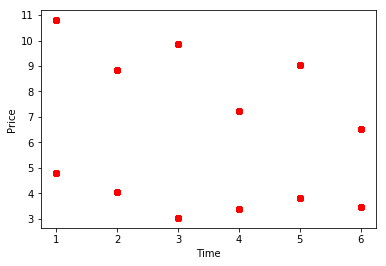

In [37]:
plt.plot(time_period,a1_obs,color ='r',marker="o",linestyle="")
plt.ylabel('Price')
plt.xlabel('Time')
plt.savefig('plots/a1.png')

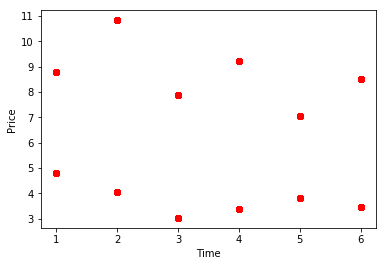

In [38]:
plt.plot(time_period,a2_obs,color ='r',marker="o",linestyle="")
plt.ylabel('Price')
plt.xlabel('Time')
plt.savefig('plots/a2.png')

In [39]:
#set up dataframe
df = np.array([market,a1_obs,a2_obs,time_period]).transpose()
df = pd.DataFrame(df,columns=['market','price1','price2','time'])

#add lag
shift_df = df.copy()
shift_df['time'] = df['time'] + 1
df = df.merge(shift_df,how='left',on=['market','time'],suffixes=['','_lag'])
df = df.dropna()

In [40]:
model = sm.OLS(df['price1'], sm.add_constant(df['price2_lag']) )
fit = model.fit()
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:                 price1   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.495e+06
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:35:37   Log-Likelihood:                -31872.
No. Observations:               50000   AIC:                         6.375e+04
Df Residuals:                   49998   BIC:                         6.377e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0303      0.005      5.802      0.0

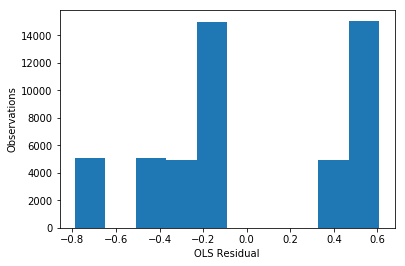

In [41]:
plt.hist(fit.resid)
plt.xlabel('OLS Residual')
plt.ylabel('Observations')
plt.savefig('plots/hist.png')

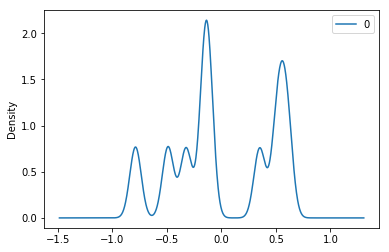

In [42]:
pd.DataFrame(fit.resid).plot(kind='density')